## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
!gdown --id 1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K

Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints-2021-05-14_08_16.json
83.4MB [00:00, 201MB/s]


In [3]:
# Opening JSON file 
f = open('/content/complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)


## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [5]:
#print the column names
for col in df.columns:
  print(col)


_index
_type
_id
_score
_source.tags
_source.zip_code
_source.complaint_id
_source.issue
_source.date_received
_source.state
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.company_public_response
_source.sub_product
_source.timely
_source.complaint_what_happened
_source.sub_issue
_source.consumer_consent_provided


In [6]:
df.shape

(78313, 22)

In [7]:
#Assign new column names
df.rename(columns ={'_index': 'index', '_type': 'type', '_id': 'id', '_score': 'score', '_source.tags': 'source_tags', 
                    '_source.zip_code': 'source_zip_code', '_source.complaint_id': 'source_complaint_id',
                    '_source.complaint_id': 'source_complaint_id', '_source.issue': 'source_issue',
                    '_source.date_received': 'source_date_received', '_source.state': 'source_state',
                    '_source.consumer_disputed': 'source_consumer_disputed', '_source.product': 'source_product',
                    '_source.company_response': 'source_company_response', '_source.company': 'source_company',
                    '_source.submitted_via': 'source_submitted_via', '_source.date_sent_to_company': 'source_date_sent_to_company',
                    '_source.company_public_response': 'source_company_public_response', '_source.sub_product': 'source_sub_product',
                    '_source.timely': 'source_timely', '_source.complaint_what_happened': 'source_complaint_what_happened',
                    '_source.sub_issue': 'source_sub_issue', '_source.consumer_consent_provided': 'source_consumer_consent_provided'}, inplace = True)

In [8]:
#Assign nan in place of blanks in the complaints column
df[df['source_complaint_what_happened']== ''] = np.nan 

In [9]:
#Remove all rows where complaints column is nan
df = df[df['source_complaint_what_happened'].notnull()]

In [10]:
df.head()

,index,type,id,score,source_tags,source_zip_code,source_complaint_id,source_issue,source_date_received,source_state,source_consumer_disputed,source_product,source_company_response,source_company,source_submitted_via,source_date_sent_to_company,source_company_public_response,source_sub_product,source_timely,source_complaint_what_happened,source_sub_issue,source_consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [11]:
df.describe(include='all')

,index,type,id,score,source_tags,source_zip_code,source_complaint_id,source_issue,source_date_received,source_state,source_consumer_disputed,source_product,source_company_response,source_company,source_submitted_via,source_date_sent_to_company,source_company_public_response,source_sub_product,source_timely,source_complaint_what_happened,source_sub_issue,source_consumer_consent_provided
count,21072,21072,21072,21072.0,3816,16427,21072,21072,21072,20929,21072,21072,21072,21072,21072,21072,2,18963,21072,21072,12896,21072
unique,1,1,21072,NaN,3,1813,21072,133,2182,60,3,17,4,1,1,2177,1,67,2,20930,189,1
top,complaint-public-v2,complaint,1624490,NaN,Older American,606XX,1624490,Managing an account,2021-03-02T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2021-03-02T12:00:00-05:00,Company has responded to the consumer and the ...,Checking account,Yes,Chase has violated 15 USC 1692 by continuing c...,Credit card company isn't resolving a dispute ...,Consent provided
freq,21072,21072,1,NaN,1848,402,1,2270,28,4001,14811,5039,16189,21072,21072,27,2,5030,21069,11,1260,21072
mean,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
translator = str.maketrans('', '', string.punctuation)
def prepare_text(text):
  text = text.lower()
  text = re.sub(r"\([^()]*\)", "", text)
  text = text.translate(translator)
  text = re.sub(r"\w*\d\w*", "", text)
  return text


In [13]:
#Write your function to Lemmatize the texts
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download("wordnet")
nltk.download("stopwords")
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
  sent = [wordnet_lemmatizer.lemmatize(word) for word in text.split() if not word in set(stopwords.words('english'))]
  return " ".join(sent)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
df['complaint_prepare'] = df.source_complaint_what_happened.apply(lambda x: prepare_text(x))
df.head()

,index,type,id,score,source_tags,source_zip_code,source_complaint_id,source_issue,source_date_received,source_state,source_consumer_disputed,source_product,source_company_response,source_company,source_submitted_via,source_date_sent_to_company,source_company_public_response,source_sub_product,source_timely,source_complaint_what_happened,source_sub_issue,source_consumer_consent_provided,complaint_prepare
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...


In [15]:
df['lemmatized_complaint'] = df.complaint_prepare.apply(lambda x: lemmatizer(x))

In [16]:
df.head()

,index,type,id,score,source_tags,source_zip_code,source_complaint_id,source_issue,source_date_received,source_state,source_consumer_disputed,source_product,source_company_response,source_company,source_submitted_via,source_date_sent_to_company,source_company_public_response,source_sub_product,source_timely,source_complaint_what_happened,source_sub_issue,source_consumer_consent_provided,complaint_prepare,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


In [17]:
df.lemmatized_complaint


1        good morning name xxxx xxxx appreciate could h...
2        upgraded xxxx xxxx card told agent upgrade ann...
10       chase card reported however fraudulent applica...
11       trying book xxxx xxxx ticket came across offer...
14       grand son give check deposit chase account fun...
                               ...                        
78303    chase card customer well decade offered multip...
78309    wednesday xxxxxxxx called chas xxxx xxxx visa ...
78310    familiar xxxx pay understand great risk provid...
78311    flawless credit yr ive chase credit card chase...
78312    roughly year ago closed account jp morgan chas...
Name: lemmatized_complaint, Length: 21072, dtype: object

In [18]:
df_clean = df[['source_complaint_what_happened', 'lemmatized_complaint']]

In [19]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean.head()

,source_complaint_what_happened,lemmatized_complaint
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...


In [20]:
#Write your function to extract the POS tags 
nlp = spacy.load("en_core_web_sm")
def extract_noun_from_sentence(text):
  doc = nlp(text)
  nouns = [tok.text for tok in doc if tok.pos_ == "NOUN"]
  return " ".join(nouns)


In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_without_pos'] = df_clean.lemmatized_complaint.apply(lambda x: extract_noun_from_sentence(x))
df_clean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,source_complaint_what_happened,lemmatized_complaint,complaint_without_pos
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check account money son money pay son time...
...,...,...,...
78303,After being a Chase Card customer for well ove...,chase card customer well decade offered multip...,card customer decade solicitation credit card ...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...
78310,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,risk consumer year trust banking deal merchant...
78311,I have had flawless credit for 30 yrs. I've ha...,flawless credit yr ive chase credit card chase...,credit credit card chase freedom problem balan...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




(array([9.297e+03, 6.324e+03, 2.700e+03, 1.300e+03, 7.300e+02, 3.060e+02,
        1.190e+02, 7.800e+01, 5.800e+01, 3.600e+01, 3.700e+01, 1.400e+01,
        9.000e+00, 1.600e+01, 7.000e+00, 5.000e+00, 6.000e+00, 5.000e+00,
        2.000e+00, 5.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([    0.  ,   203.22,   406.44,   609.66,   812.88,  1016.1 ,
         1219.32,  1422.54,  1625.76,  1828.98,  2032.2 ,  2235.42,
         2438.64,  2641.86,  2845.08,  3048.3 ,  3251.52,  3454.74,
         3657.96,  3861.18,  4064.4 ,  4267.62,  4470.84,  4674.06,
         4877.28,  5080.5 ,  5283.72,  5486.94,  5690.16,  5893.38,
         6096.6 ,  6299.82,  6503.04

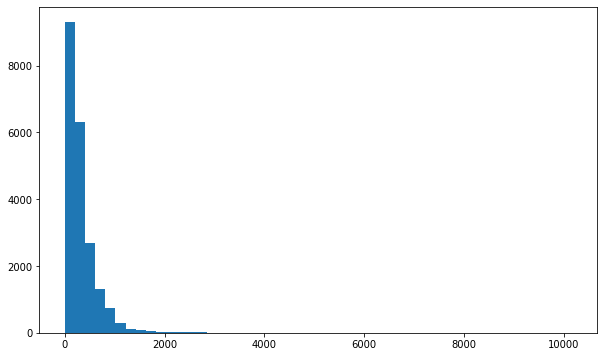

In [22]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_without_pos]
plt.hist(doc_lens, bins = 50)

#### Find the top 40 words by frequency among all the articles after processing the text.

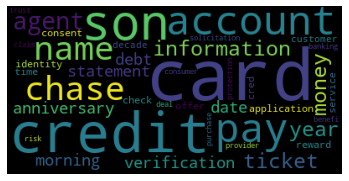

In [23]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
#!pip install wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud(max_words=40).generate(str(df_clean.complaint_without_pos))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [24]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_without_pos'].str.replace('-PRON-', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
df_clean.head()

,source_complaint_what_happened,lemmatized_complaint,complaint_without_pos,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,morning name chase debt verification statement...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,card application identity consent service cred...,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check account money son money pay son time...,son check account money son money pay son time...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [93]:
# help(CountVectorizer)

In [103]:
from nltk.util import ngrams
def ngram_convertor(df,n=3):
  word_vectorizer = CountVectorizer(ngram_range=(n,n), analyzer='word')
  sparse_matrix = word_vectorizer.fit_transform(df['Complaint_clean'])
  frequencies = sum(sparse_matrix).toarray()[0]
  ngrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
  return ngrams

In [104]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigrams = ngram_convertor(df_clean, 1)

#Top 30 Unigrams
unigrams.sort_values(by="frequency", ascending = False).head(30)

,frequency
account,40928
chase,34151
credit,29960
card,29163
payment,20197
time,15408
charge,12002
money,11487
day,10396
check,9964


In [105]:
#Print the top 10 words in the unigram frequency
unigrams.sort_values(by="frequency", ascending = False).head(10)

,frequency
account,40928
chase,34151
credit,29960
card,29163
payment,20197
time,15408
charge,12002
money,11487
day,10396
check,9964


In [106]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = ngram_convertor(df_clean, 2)

In [107]:
#Print the top 10 words in the bigram frequency
bigrams.sort_values(by="frequency", ascending = False).head(10)

,frequency
credit card,11940
credit report,3427
account account,2531
customer service,2425
chase credit,2161
card account,1719
account chase,1695
chase account,1686
credit score,1619
phone call,1570


In [108]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = ngram_convertor(df_clean, 3)

In [109]:
#Print the top 10 words in the trigram frequency
trigrams.sort_values(by="frequency", ascending = False).head(10)

,frequency
chase credit card,1459
credit card account,1009
credit card company,858
credit card chase,628
credit card credit,602
card credit card,530
account credit card,417
inquiry credit report,391
charge credit card,374
credit report credit,355


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [33]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
#All masked texts has been removed
df_clean

,source_complaint_what_happened,lemmatized_complaint,complaint_without_pos,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,morning name chase debt verification statement...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,card application identity consent service cred...,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check account money son money pay son time...,son check account money son money pay son time...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,chase card customer well decade offered multip...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...
78310,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,risk consumer year trust banking deal merchant...,risk consumer year trust banking deal merchant...
78311,I have had flawless credit for 30 yrs. I've ha...,flawless credit yr ive chase credit card chase...,credit credit card chase freedom problem balan...,credit credit card chase freedom problem balan...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [35]:
# help(TfidfVectorizer)

In [36]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
tfidf_vectors = vectorizer.fit_transform(df_clean.Complaint_clean)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [37]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_df = pd.DataFrame(tfidf_vectors.toarray(), columns= vectorizer.get_feature_names(), index=df_clean.index)
doc_term_df.head()

,aaaratings,ab,abandonment,abatement,abet,abhorrent,abide,abiding,ability,absence,absolve,absorb,absurdity,abundance,abuse,abusive,acccounts,acceleration,accent,accept,acceptance,access,accessibility,accessing,accessory,accident,accommodation,accomplice,accomplish,accont,accord,accordance,according,accouint,accoun,accound,account,accountability,accountant,accountbalance,...,workmanship,workout,workplace,workshop,world,worm,worry,worth,worthiness,worthlessness,woudl,wouldbe,wouls,wound,wout,wrap,wreck,wrecking,wrist,writ,write,writeoff,writer,writing,wrong,wrongdoing,wwwchasecom,wwwconsumerfinancegov,yard,yea,year,yelling,yelp,yesterday,yield,yoga,yr,zip,zombie,zone
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126771,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069285,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [38]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [39]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=5, random_state=40)#write your code here

In [40]:
W1 = nmf_model.fit_transform(doc_term_df)
len(vectorizer.get_feature_names())

5824

In [41]:
H1 = nmf_model.components_

In [42]:
W1

array([[7.46486085e-03, 1.09014915e-02, 7.45737307e-03, 8.40891433e-03,
        3.03644111e-02],
       [1.33759753e-05, 1.12738848e-02, 2.74006545e-03, 1.33504597e-02,
        5.79999568e-03],
       [0.00000000e+00, 4.88346009e-02, 0.00000000e+00, 1.98972672e-03,
        3.07114301e-04],
       ...,
       [1.05674403e-02, 1.09616944e-02, 0.00000000e+00, 2.39885523e-02,
        1.08102936e-02],
       [3.42780140e-03, 5.07171766e-02, 9.32849774e-02, 1.68875183e-02,
        5.81006301e-04],
       [2.88926158e-02, 3.56186142e-02, 7.20119341e-02, 5.88626916e-03,
        6.92080498e-03]])

In [43]:
H1

array([[0.00000000e+00, 1.10947754e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.59052779e-03, 8.82105916e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.35530029e-04, ...,
        9.83366561e-04, 0.00000000e+00, 2.72462365e-03],
       [7.45726163e-05, 1.42153252e-04, 9.63806532e-05, ...,
        3.35752710e-03, 0.00000000e+00, 2.63937020e-03],
       [1.02068022e-03, 1.49772000e-03, 9.36935512e-04, ...,
        1.26244898e-03, 1.94115054e-03, 3.44418277e-03]])

In [44]:
#Print the Top15 words for each of the topics
num_words=15

vocab = np.array(vectorizer.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]
topics

['account check money fund bank deposit chase branch day number business transfer customer transaction time',
 'credit card report inquiry chase account score company limit application debt balance year information letter',
 'payment balance month fee statement pay date time day chase auto error credit car year',
 'charge card transaction chase dispute merchant fee claim fraud purchase service refund time email phone',
 'loan mortgage modification chase home year property rate time document letter sale debt information foreclosure']

In [45]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean.Complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['Topic_tar'] = significant_topic
df_clean['Topic_tar'] = significant_topic


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
df_clean.head()

,source_complaint_what_happened,lemmatized_complaint,complaint_without_pos,Complaint_clean,Topic_tar
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,morning name chase debt verification statement...,4
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,card application identity consent service cred...,card application identity consent service cred...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check account money son money pay son time...,son check account money son money pay son time...,0


In [47]:
df_clean.shape

(21072, 5)

In [48]:
df_doc_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic_tar
Doc0,0.01,0.01,0.01,0.01,0.03,4
Doc1,0.00,0.01,0.00,0.01,0.01,1
Doc2,0.00,0.05,0.00,0.00,0.00,1
Doc3,0.01,0.06,0.00,0.00,0.02,1
Doc4,0.05,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...
Doc21067,0.00,0.09,0.02,0.04,0.00,1
Doc21068,0.01,0.01,0.00,0.04,0.01,3
Doc21069,0.01,0.01,0.00,0.02,0.01,3
Doc21070,0.00,0.05,0.09,0.02,0.00,2


In [49]:
#Assign the best topic to each of the cmplaints in Topic Column

# df_clean['Topic'] = #write your code to assign topics to each rows.

In [50]:
df_backup = df_clean

In [51]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic_tar').head(5).sort_values('Topic_tar')

,source_complaint_what_happened,lemmatized_complaint,complaint_without_pos,Complaint_clean,Topic_tar
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check account money son money pay son time...,son check account money son money pay son time...,0
17,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restricted account debi...,card branch customer service representative ac...,card branch customer service representative ac...,0
24,mishandling of this account by Chase auto and ...,mishandling account chase auto xxxx,,,0
27,I opened an account with chase bank on XXXX an...,opened account chase bank xxxx used code xxxx ...,bonus account deposit bonus day xxxx deposit a...,bonus account deposit bonus day deposit accou...,0
35,I opened the saving account for the {$25.00} b...,opened saving account bonus supposed received ...,account bonus bonus auto transfer checking sav...,account bonus bonus auto transfer checking sav...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,card application identity consent service cred...,card application identity consent service cred...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
15,Can you please remove inquiry,please remove inquiry,inquiry,inquiry,1
23,I have a Chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,credit card data credit report company issue,credit card data credit report company issue,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [52]:
#Create the dictionary of Topic names and Topics
Topic_names = {
    0: "Bank Account services",
    1: "Credit card or prepaid card",
    2: "Others",
    3: "Theft/Dispute Reporting",
    4: "Mortgage/Loan"
}

In [53]:
df_clean.shape

(21072, 5)

In [54]:
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic_tar'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
df_clean.describe()

,Topic_tar
count,21072.000000
mean,1.753844
std,1.450661
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,4.000000


In [56]:
df_clean.shape

(21072, 6)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [57]:
#Create the dictionary again of Topic names and Topics



In [58]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
# training_data=

In [59]:
# training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [60]:
#Write your code to get the Vector count
count_vect = CountVectorizer()
X = count_vect.fit_transform(df_clean.source_complaint_what_happened)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X)
y= df_clean.Topic_tar


#Write your code here to transform the word vector to tf-idf

In [61]:
X_train_tfidf.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11727692, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07809665, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [62]:
y.head()

1     4
2     1
10    1
11    1
14    0
Name: Topic_tar, dtype: int64

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=0.2, random_state=40)

In [64]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16857, 29725)
(16857,)
(4215, 29725)
(4215,)


You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [65]:
# Write your code here to build any 3 models and evaluate them using the required metrics
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

### Logistic Regression

In [66]:
from sklearn.naive_bayes import MultinomialNB

In [67]:
clf = MultinomialNB().fit(X_train, y_train)

In [68]:
evaluate_model(clf)

Train Accuracy : 0.7008364477665064
Train Confusion Matrix:
[[4135  306    1   42    5]
 [ 517 3419    0  201   18]
 [ 808  765   74   94  199]
 [ 934  253    0 2355   13]
 [ 544  332    0   11 1831]]
--------------------------------------------------
Test Accuracy : 0.6588374851720048
Test Confusion Matrix:
[[1005   88    0   21    5]
 [ 161  804    0   70    2]
 [ 200  208   12   32   46]
 [ 282   83    0  523    4]
 [ 147   85    0    4  433]]


### Decision Tree

In [69]:
from sklearn.tree import DecisionTreeClassifier

In [70]:
dt = DecisionTreeClassifier(random_state=42, min_samples_leaf=30, criterion="entropy")

In [71]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [72]:
evaluate_model(dt)

Train Accuracy : 0.8287951592810109
Train Confusion Matrix:
[[3781  235   92  264  117]
 [ 142 3641  104  201   67]
 [  67  100 1560   71  142]
 [ 354  303   61 2716  121]
 [ 130   99   97  119 2273]]
--------------------------------------------------
Test Accuracy : 0.7781731909845789
Test Confusion Matrix:
[[882  75  26 107  29]
 [ 49 863  31  73  21]
 [ 22  35 371  15  55]
 [121  82  18 621  50]
 [ 31  32  29  34 543]]


In [73]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [74]:

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [75]:
# help(RandomizedSearchCV)

In [76]:
grid_search = GridSearchCV(dt, params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [77]:
%%time
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  8.8min finished


CPU times: user 10.2 s, sys: 585 ms, total: 10.8 s
Wall time: 8min 54s


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=30,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [78]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.045122,0.019937,0.005317,0.000327,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.547746,0.533808,0.543459,0.545239,0.539009,0.541852,0.004931,41
1,1.023790,0.013457,0.006196,0.001410,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.547746,0.533808,0.543459,0.545239,0.539009,0.541852,0.004931,41
2,1.002317,0.007426,0.004916,0.000046,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.547746,0.533808,0.543459,0.545239,0.539009,0.541852,0.004931,41
3,0.991828,0.005497,0.004978,0.000114,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.547746,0.533808,0.543459,0.545239,0.539009,0.541852,0.004931,41
4,0.981549,0.009087,0.005023,0.000112,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.547746,0.533808,0.543459,0.545239,0.539009,0.541852,0.004931,41


In [79]:
dt_best = grid_search.best_estimator_
evaluate_model(dt_best)

Train Accuracy : 0.8391766031915525
Train Confusion Matrix:
[[3826  149   81  332  101]
 [ 160 3594   72  276   53]
 [  77   98 1563   96  106]
 [ 293  202   58 2924   78]
 [  96   81  105  197 2239]]
--------------------------------------------------
Test Accuracy : 0.7912218268090154
Test Confusion Matrix:
[[905  54  28 102  30]
 [ 50 839  22 106  20]
 [ 22  43 365  26  42]
 [ 95  65  18 690  24]
 [ 23  29  26  55 536]]


In [80]:
### Accuracy from Decision tree is around 79%


### Random Forest
---



In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
rfc = RandomForestClassifier(random_state=40, max_depth=3, min_samples_leaf=30)

In [83]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=40, verbose=0,
                       warm_start=False)

In [84]:
evaluate_model(rfc)

Train Accuracy : 0.5142670700599158
Train Confusion Matrix:
[[4318  165    0    6    0]
 [1052 3061    0   41    1]
 [1414  491    0   20   15]
 [2224  338    0  993    0]
 [2198  220    0    3  297]]
--------------------------------------------------
Test Accuracy : 0.5103202846975089
Test Confusion Matrix:
[[1068   50    0    1    0]
 [ 260  767    0   10    0]
 [ 346  139    0    7    6]
 [ 544   91    0  257    0]
 [ 555   52    0    3   59]]


In [85]:
rfc = RandomForestClassifier(random_state=40)

In [86]:
# Using Randomised Search CV
params = {
    'max_depth': [1, 2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 5, 10, 20, 50, 100],
    'n_estimators': [5, 10, 30, 50, 100, 200]
}

In [87]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())
# help(RandomizedSearchCV)

In [88]:
random_search_rfc = RandomizedSearchCV(estimator=rfc, param_distributions=params, 
                                   cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [89]:
random_search_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [90]:
random_search_rfc.best_score_

0.6911071968605293

In [91]:
rfc_best = random_search_rfc.best_estimator_
evaluate_model(rfc_best)

Train Accuracy : 0.7458622530699413
Train Confusion Matrix:
[[4219  262    0    5    3]
 [ 236 3826    0   89    4]
 [ 738  671  250  107  174]
 [ 776  372    0 2401    6]
 [ 436  394    0   11 1877]]
--------------------------------------------------
Test Accuracy : 0.6892052194543298
Test Confusion Matrix:
[[1032   80    0    6    1]
 [  84  897    0   56    0]
 [ 186  200   29   28   55]
 [ 245  118    0  523    6]
 [ 131  108    1    5  424]]
